# Geostatistical Variogram Tutorial in R for Engineers and Geoscientists 
### Michael Pyrcz, Associate Professor, University of Texas at Austin, 

#### Contacts: [Twitter/@GeostatsGuy](https://twitter.com/geostatsguy) | [GitHub/GeostatsGuy](https://github.com/GeostatsGuy) | [www.michaelpyrcz.com](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446)

A tutorial/demonstration of spatial variogram analysis workflow untilizing the gstat package by Pedesma, E. The docs are at https://cran.r-project.org/web/packages/gstat/index.html.  I found Pedesma's Meuse tutorial very helpful (https://cran.r-project.org/web/packages/gstat/vignettes/gstat.pdf).  Also, appreciation to Pebesma for assistance through answering questions. For this demonstration we use a 200 well 2D porosity dataset (file: 2D_MV_200Wells.csv) that may be found at https://github.com/GeostatsGuy/GeoDataSets.  I used this tutorial in my Introduction to Geostatistics undergraduate class (PGE337 at UT Austin) as part of a first introduction to R for the engineering undergraduate students. It is assumed that students have no previous R nor geostatistics experience; therefore, all steps of the code and workflow are explored and described. This tutorial is augmented with course notes.

#### Load the required libraries


In [2]:
library(gstat)                                 # geostatistical methods by Edzer Pebesma
library(sp)                                    # spatial points addition to regular data frames

Warning message:
"package 'gstat' was built under R version 3.4.3"Warning message:
"package 'sp' was built under R version 3.4.3"

If you get an error, you may have to first go to "Tools/Install Packages..." to install these packages. Just type in the names one at a time into the package field and install.  The package names should autocomplete (helping you make sure you got the right package name), and the install process is automatic, with the possibility of installing other required dependency packages.  Previously I had an issue with packages not being found after install that was resolved with a reboot.

#### Declare functions

I was surprised that there isn't a built in method to transform a dataframe column or data vector to standard normal, Gaussian with a mean of zero, $\overline{x} = 0.0$ and a standard deviation $\sigma = 1.0$.  I found this function by Ashton Shortridge (2008) and included it here.  Just apply with the raw data as a vector, $x$, and it returns an object with the normal score values as a member vector, '[my_transform_object]$nscore'. 

In [28]:
nscore <- function(x) {                        # by Ashton Shortridge, 2008
  # Takes a vector of values x and calculates their normal scores. Returns 
  # a list with the scores and an ordered table of original values and
  # scores, which is useful as a back-transform table. See backtr().
  nscore <- qqnorm(x, plot.it = FALSE)$x  # normal score 
  trn.table <- data.frame(x=sort(x),nscore=sort(nscore))
  return (list(nscore=nscore, trn.table=trn.table))
}

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).

In [30]:
setwd("C:/PGE337")

You will have to change this on Mac (e.g. "~/PGE").  If stuck consider using the GUI to set the working directory. Navigate to the working folder in 'Files' and then go to 'Files/More/Set As Working Directory' in the files pane to the right.  You can then copy the command from the console.

#### Read the data table

Copy the 2D_MV_200Wells.csv comma delimited file from https://github.com/GeostatsGuy/GeoDataSets to your working directory.

In [31]:
mydata = read.csv("2D_MV_200Wells.csv")          # read in comma delimited data file

Let's visualize the first several rows of our data so we can make sure we successfully loaded the data file.

In [32]:
head(mydata)                                   # preview first several rows in the console

X,Y,facies_threshold_0.3,porosity,permeability,acoustic_impedance
565,1485,1,0.1184,6.170,2.009
2585,1185,1,0.1566,6.275,2.864
2065,2865,2,0.1920,92.297,3.524
3575,2655,1,0.1621,9.048,2.157
1835,35,1,0.1766,7.123,3.979
3375,2525,1,0.1239,1.468,2.337


The columns are variables with variable names at the top and the rows are samples.

#### Data preparation and cleaning

First, we must convert the dataframe to a spatial points dataframe.  We do this by defining the $X$ and $Y$ coordinates.  First we check the class to demonstrate that we have a dataframe, then we define the coordinates and check again and confirm that the dataframe object has upgraded to a spatial points dataframe.

In [33]:
class(mydata)                                  # confirms that it is a dataframe
coordinates(mydata) = ~X+Y                     # indicate the X, Y spatial coordinates

[1] "data.frame"

Let's check the dataset by producing summary statistics and visualizing the first several samples' spatial coordinates.

In [34]:
summary(mydata)                                # confirms a spatial points dataframe
head(coordinates(mydata))                      # check the first several coordinates

Object of class SpatialPointsDataFrame
Coordinates:
  min  max
X  25 3955
Y  35 3995
Is projected: NA 
proj4string : [NA]
Number of points: 200
Data attributes:
 facies_threshold_0.3    porosity       permeability      acoustic_impedance
 Min.   :1.00         Min.   :0.0500   Min.   :  0.0158   Min.   :2.009     
 1st Qu.:1.00         1st Qu.:0.1322   1st Qu.:  1.3667   1st Qu.:2.483     
 Median :1.00         Median :0.1502   Median :  4.8255   Median :2.965     
 Mean   :1.33         Mean   :0.1493   Mean   : 25.2875   Mean   :3.000     
 3rd Qu.:2.00         3rd Qu.:0.1742   3rd Qu.: 14.5970   3rd Qu.:3.527     
 Max.   :2.00         Max.   :0.2232   Max.   :463.6410   Max.   :3.984     

,X,Y
1,565,1485
2,2585,1185
3,2065,2865
4,3575,2655
5,1835,35
6,3375,2525


For calculation of the experimental variograms we often work with Gaussian transformed data.  We do this since the variogram of the Gaussian transform of the data is required for sequential Gaussian simulation.  In addition, the Gaussian transform often results in more interpretable variograms.

In [35]:
npor.trn = nscore(mydata$porosity)             # normal scores transform
mydata[["NPorosity"]]<-npor.trn$nscore         # append the normal scores transform 
head(mydata)                                   # check the result

   coordinates facies_threshold_0.3 porosity permeability acoustic_impedance
1  (565, 1485)                    1   0.1184        6.170              2.009
2 (2585, 1185)                    1   0.1566        6.275              2.864
3 (2065, 2865)                    2   0.1920       92.297              3.524
4 (3575, 2655)                    1   0.1621        9.048              2.157
5   (1835, 35)                    1   0.1766        7.123              3.979
6 (3375, 2525)                    1   0.1239        1.468              2.337
   NPorosity
1 -0.9842350
2  0.1700129
3  1.3563117
4  0.3651492
5  0.7306385
6 -0.8505849

We can check the summary statistics of the new variable.

In [36]:
summary(mydata$NPorosity)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-2.8070 -0.6706  0.0000  0.0000  0.6706  2.8070 

Now let's visualize the original porosity data distribution and also check the distribution of the normal score transform of the porosity data. 

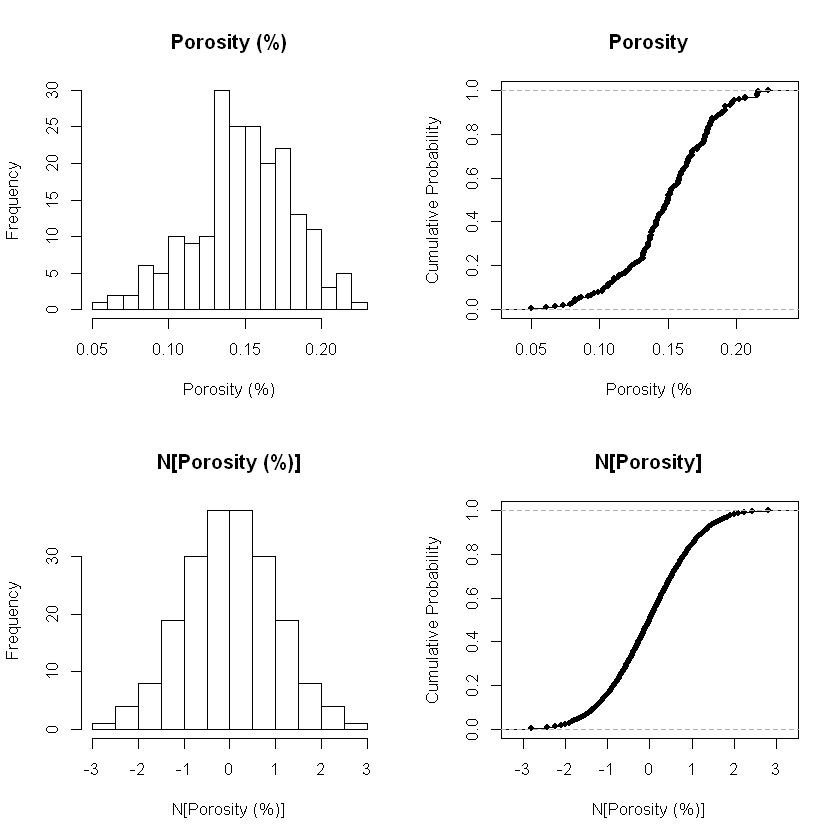

In [37]:
par(mfrow=c(2,2))                              # set up a 2x2 matrix of plots 
hist(mydata$porosity,main="Porosity (%)",xlab="Porosity (%)",nclass = 15) # histogram
plot(ecdf(mydata$porosity),main="Porosity",xlab="Porosity (%",ylab="Cumulative Probability") # CDF
hist(mydata$NPorosity,main="N[Porosity (%)]",xlab="N[Porosity (%)]",nclass = 15) # histogram
plot(ecdf(mydata$NPorosity),main="N[Porosity]",xlab="N[Porosity (%)]",ylab="Cumulative Probability") #CDF

#### Spatial visualization

To assist with infering variogram parameters we should check the spatial arangement of the data. We will look at the general coverage of the data over the area of interest (is there clustering or unsampled areas?), degree of continuity and for potential trends.  Let's start with a simple bubble plot.  We'll declare some plotting parameters first.  These are simply the color thresholds for the posted porsity values.

In [38]:
cuts = c(.05,.07,.09,.11,.13,.15,.17,.19,.21,.23)

First let's look at a simple bubble plot.  Size of the circles are scaled to the magnitude of the local porosity measure.

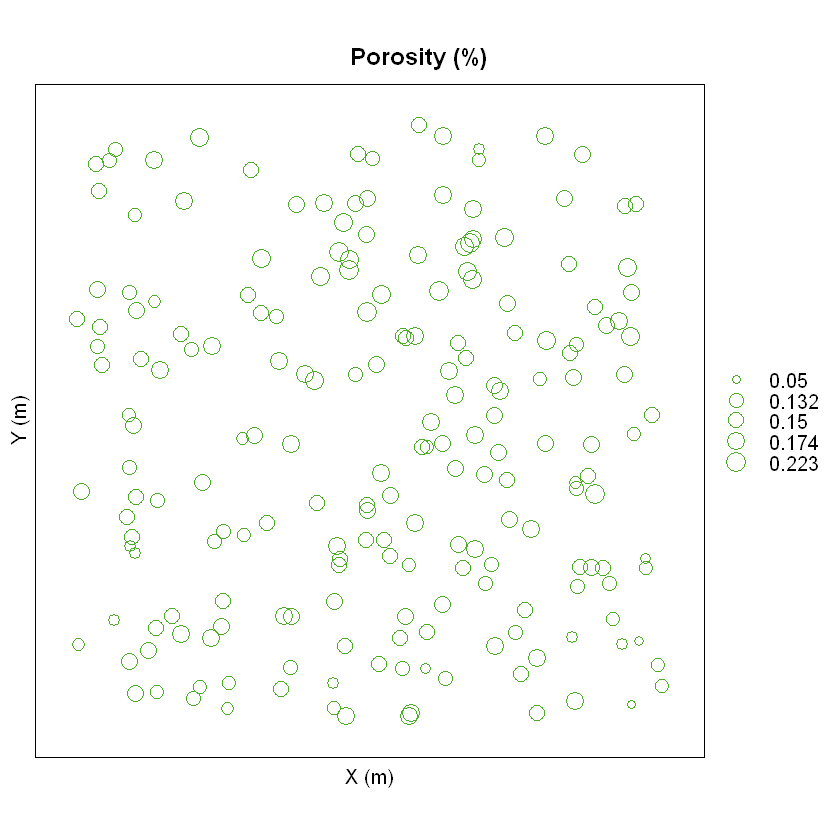

In [39]:
bubble(mydata, "porosity", fill = FALSE, maxsize = 2, main ="Porosity (%)", identify = FALSE,xlab = "X (m)", ylab = "Y (m)")

Also, we could review a porosity data location map. 

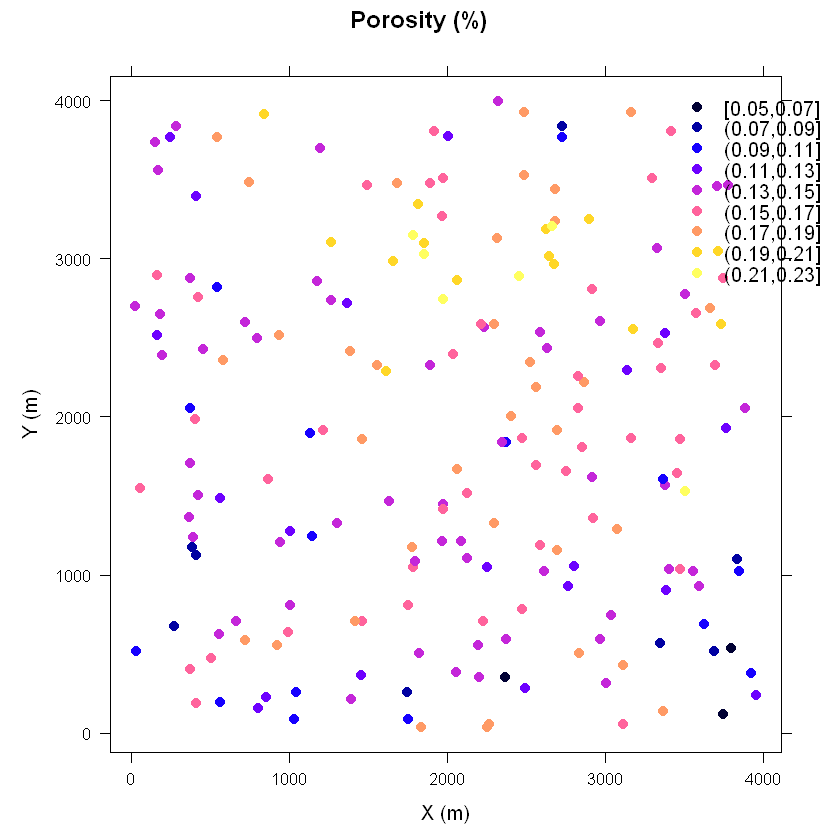

In [40]:
spplot(mydata, "porosity", do.log = TRUE,      # location map of porosity data
       key.space=list(x=.85,y=0.97,corner=c(0,1)),cuts = cuts,
       scales=list(draw=T),xlab = "X (m)", ylab = "Y (m)",main ="Porosity (%)")

We have good coverage of the area of interest (estimation grid) with a nominal, minimal data spacing of about 200 m.  There doesn't seem to be a consistent trend, but there is likely a significant nugget effect, indicated by adjacent high and low values.

#### Isotropic spatial continuity

We are ready to do some variogram analysis. First let's calculate and isotropic experimental variogram and fit a model for the normal scores transformed porosity 2D dataset. 


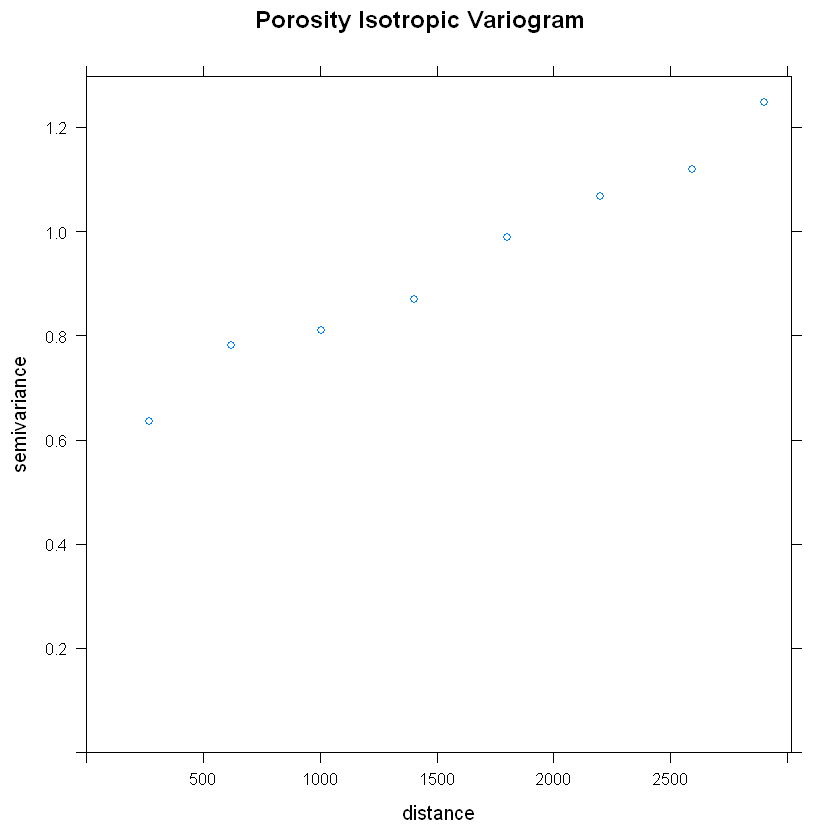

In [3]:
por.vg.iso = variogram(NPorosity~1,mydata,cutoff = 3000,width =400,alpha = 0.0,tol.hor=90.0) # isotropic N[porosity]
plot(por.vg.iso,scaled = FALSE,var.lines = TRUE,main="Porosity Isotropic Variogram")

By setting the horizontal angle tolerance, $tol.hor = 90.0$ we get an isotropic 2D experimental variogram (given isotropic the directional azimuth, $alpha$, is not impactful).  We set the bin width, $width = 400$, based on iteration for interpretable results and guided by data spacing.  We model to about $\frac{1}{2}$ of the data extents, $2,000 m$, but we display results out to $3,000 m$. 

Note that the sill is missing from the plot.  We cannot add a sill, but keep in mind that the variance of the normal scores transformed porosity values is one, $\sigma^{2} = 1.0$, therefore the sill is $1.0$. We should model to the sill for simulation.  Also, as expected there appears to be significant nugget effect.

model,psill,range,kappa,ang1,ang2,ang3,anis1,anis2
Nug,0.4,0,0.0,0,0,0,1,1
Exp,0.6,800,0.5,0,0,0,1,1


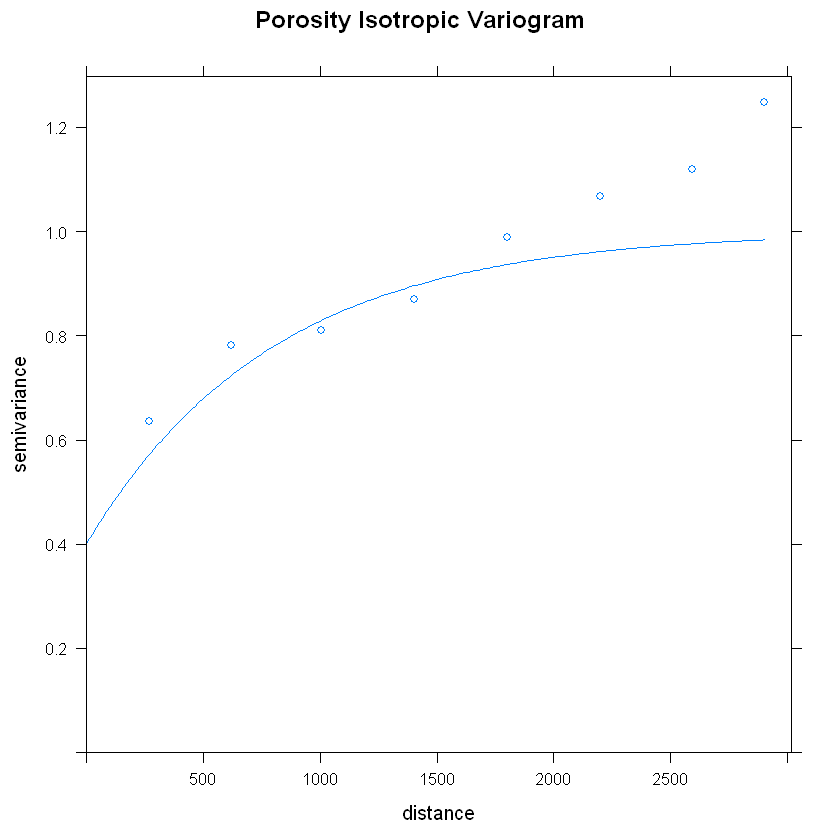

In [4]:
por.vm.iso <- vgm(psill = 0.6, "Exp", 800, anis = c(0, 0, 0, 1.0, 1.0),nugget=0.4)
por.vm.iso                                     # check the variogram model parameters

plot(por.vg.iso,por.vm.iso,main="Porosity Isotropic Variogram") # use the built in gstat variogram plot

#### Anisotropic variogram calculation and modeling

Now let's calculate a variogram map to identify possible directionality.  Variogram maps provide the variogram values over a mesh of binned offsets from the center node.  It is like calculating the variogram for all possible directions all at once. 

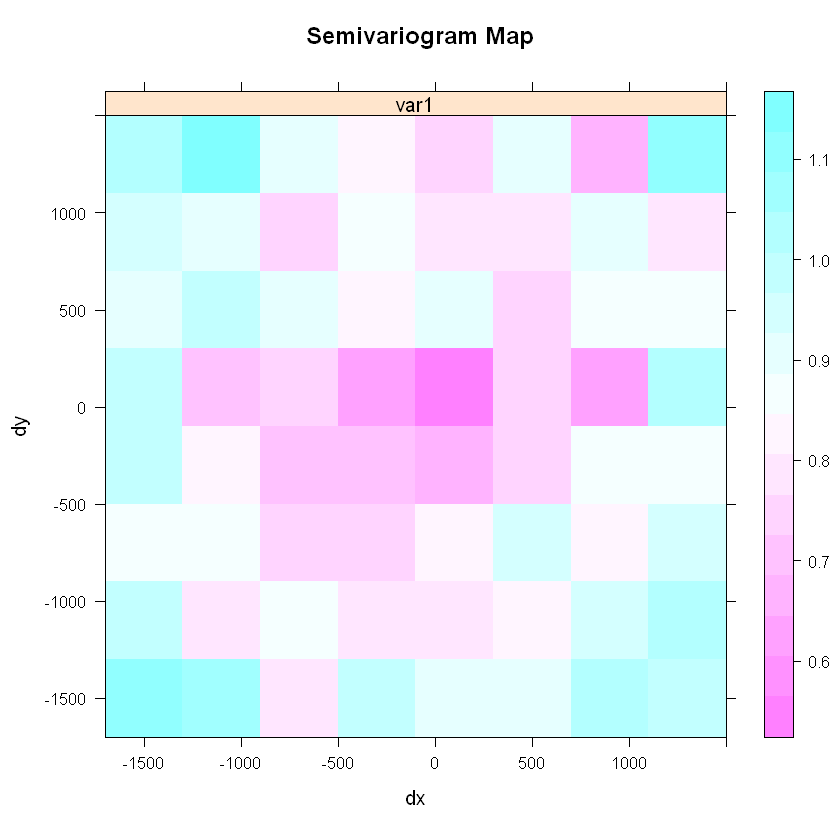

In [5]:
par(mfrow=c(2,2))                              # set up a 2x32 matrix of plots    
plot(variogram(NPorosity~1,mydata, cutoff=1500, width=400, map=TRUE),main = "Semivariogram Map",max=1.0)

We should also check the number of pairs available for each bin to ensure we have reliable information.

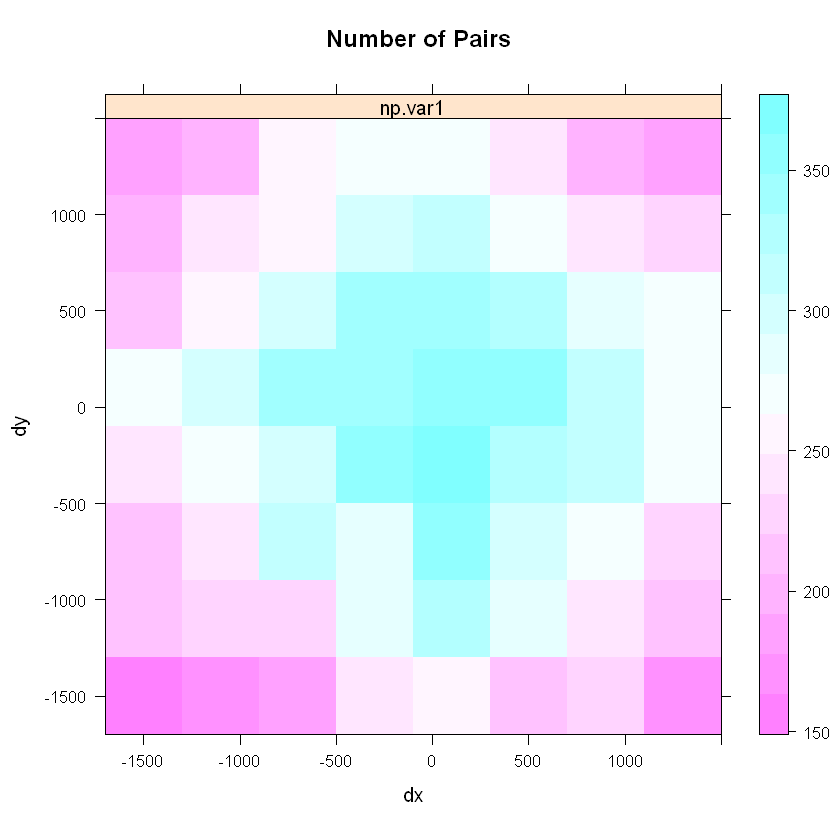

In [6]:
plot(variogram(NPorosity~1,mydata, cutoff=1500, width=400, map=TRUE),main = "Number of Pairs",np=TRUE)

From the variogram map we can infer that there is anisotropy with azimuth $035$ as the major continuity direction and $125$ as the minor continuity direction.  We can now calculate and model the variogram in these primary continuity directions to formulate a valid anistropic spatial continuity model.

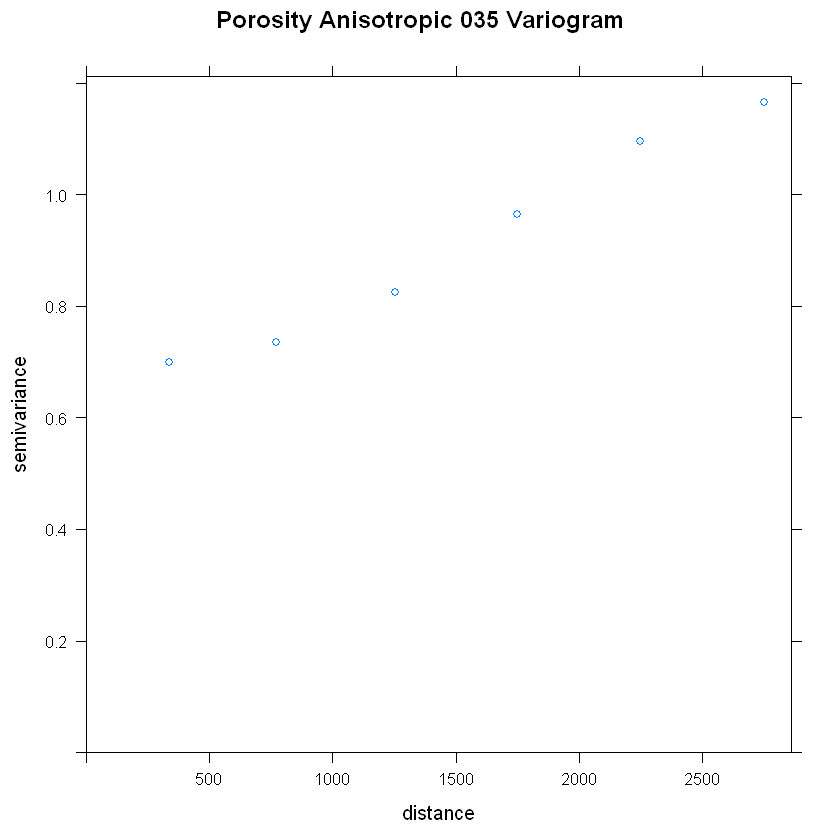

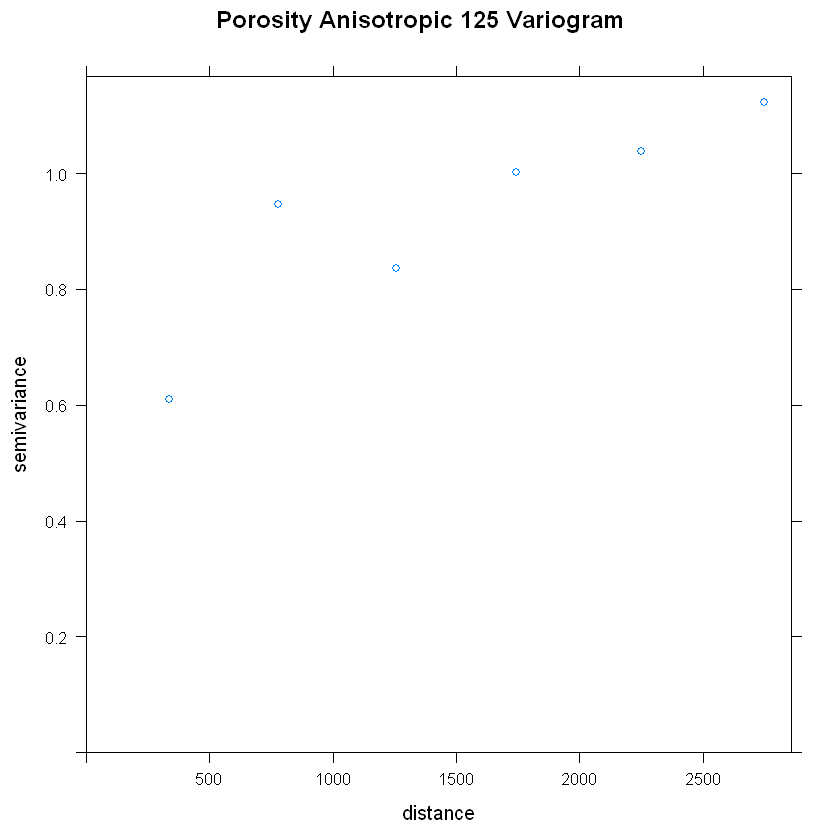

In [7]:
por.vg.035 = variogram(NPorosity~1,mydata,cutoff = 3000,width =500,alpha = 35.0,tol.hor=22.5) # azimuth 035       
por.vg.125 = variogram(NPorosity~1,mydata,cutoff = 3000,width =500,alpha = 125.0,tol.hor=22.5) # azimuth 125

plot(por.vg.035,main="Porosity Anisotropic 035 Variogram")
plot(por.vg.125,main="Porosity Anisotropic 125 Variogram")

Note that anisotropy is parameterized in variogram models as a vector (azimuth,dip,plunge,hratio,vratio) in $3D$ and (azimuth,hratio) in $2D$.  Note that the anisotropic model is parameterized with an array with (azimuth, hratio). $hratio$ is a fraction $< 1.0$.  For example $0.1$ would indicate a $10:1$ major to minor continuity range ratio. For a positive definite model, we use the same structure(s) and contributions in all directions, we just vary the range parameters.   

We can go ahead and fit an anisotropic model with major conitnuity direction, $035$ azimuth, and $2:1$ continuity ratio between major and minor continuity directions. This results in a range of $800 m$ in $035$ and $400 m$ in $125$. 

model,psill,range,kappa,ang1,ang2,ang3,anis1,anis2
Nug,0.4,0,0.0,0,0,0,1.0,1
Exp,0.6,800,0.5,35,0,0,0.5,1


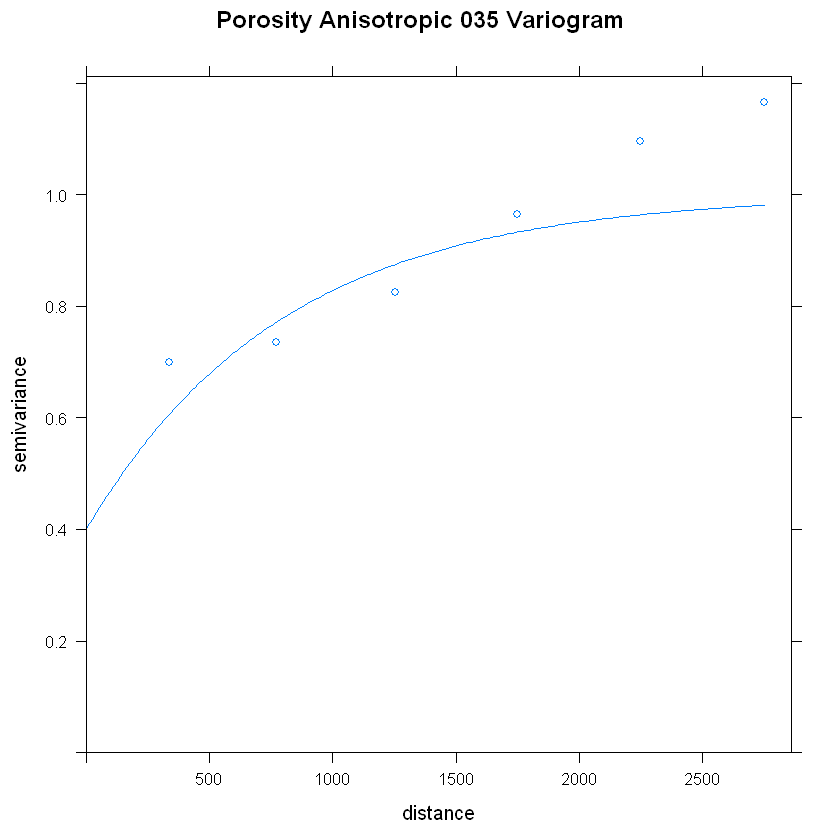

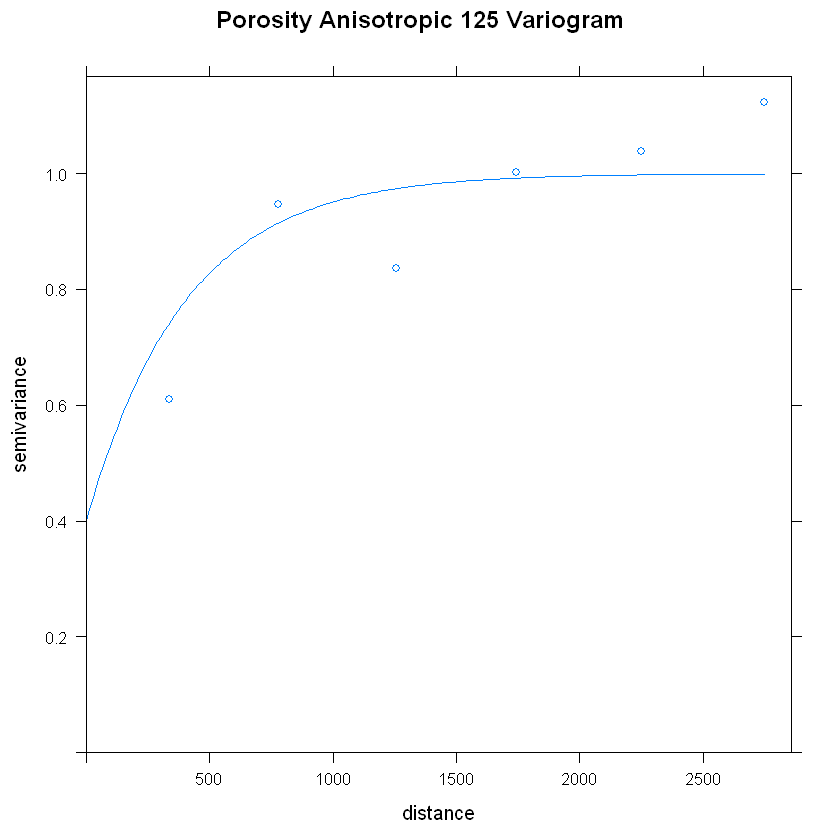

In [8]:
por.vm.ani <- vgm(psill = 0.6, "Exp", 800, anis = c(035, 0.5),nugget=0.4)
por.vm.ani                                     # check the variogram model parameters 

plot(por.vg.035,por.vm.ani,main="Porosity Anisotropic 035 Variogram") # use the built in gstat variogram plot
plot(por.vg.125,por.vm.ani,main="Porosity Anisotropic 125 Variogram") # use the built in gstat variogram plot

#### Automated, anisotropic variogram modeling

The gstat module includes auto-fitting methods.  Let's see if we can use auto-fitting to try to improve the variogram model. 

model,psill,range,kappa,ang1,ang2,ang3,anis1,anis2
Nug,0.4,0.000,0.0,0,0,0,1.0,1
Exp,0.6,880.565,0.5,35,0,0,0.5,1


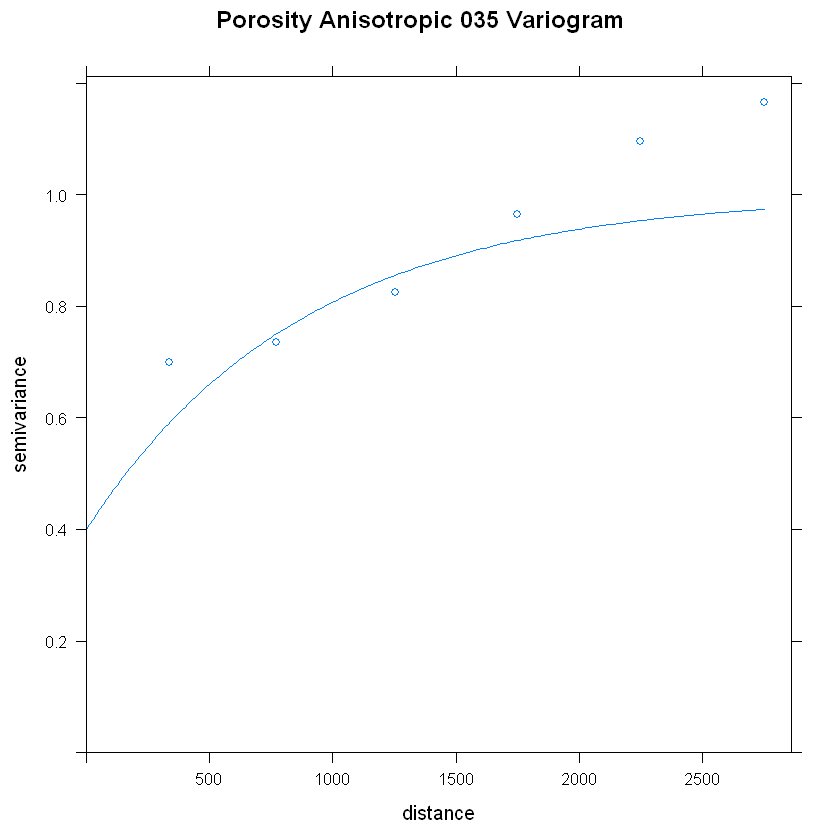

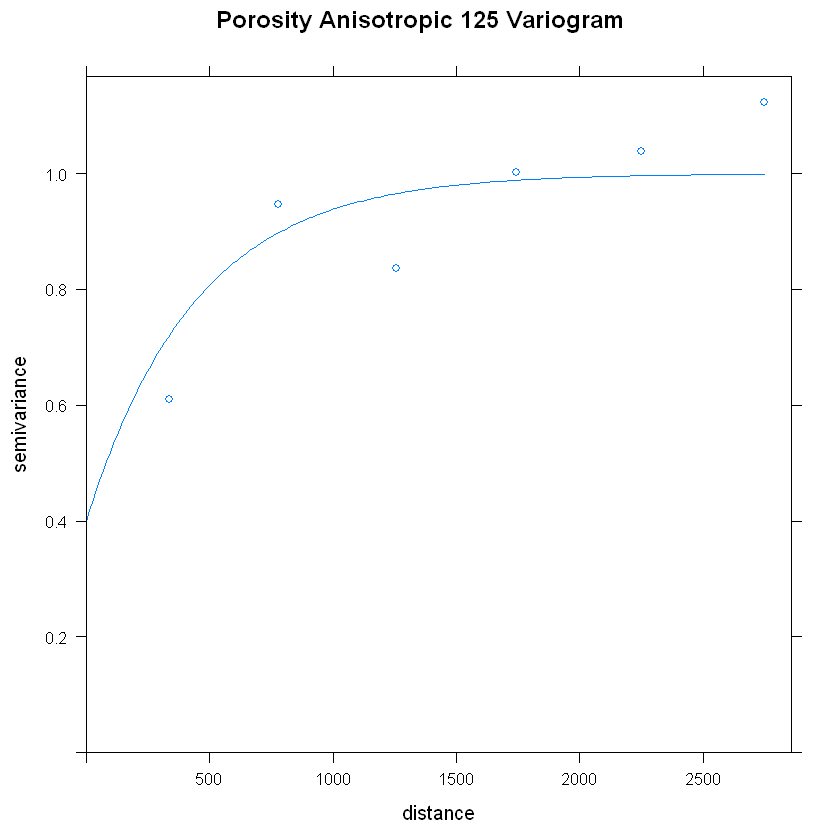

In [9]:
por.vm.ani.auto <- fit.variogram(por.vg.iso,por.vm.ani,fit.sills = FALSE)
por.vm.ani.auto                                # check the autofit parameters and compare to our fit
plot(por.vg.035,por.vm.ani.auto,main="Porosity Anisotropic 035 Variogram")
plot(por.vg.125,por.vm.ani.auto,main="Porosity Anisotropic 125 Variogram")

We check the resulting parameters and compare them to our fit model parameters.  The autofit varies from our model fits, but not significanlty.

#### Custom vairogram plots

Let's make our own custom variogram plots.  The ones provided with the gstat package are somewhat limited. My main concern is the inability to plot the sill, essential for interpretation.  They also cannot be used with matrix of plots.  This requires quite a bit more coding, but for completeness we demonstrate this for the isotropic and anisotropic experimental and model variograms.  

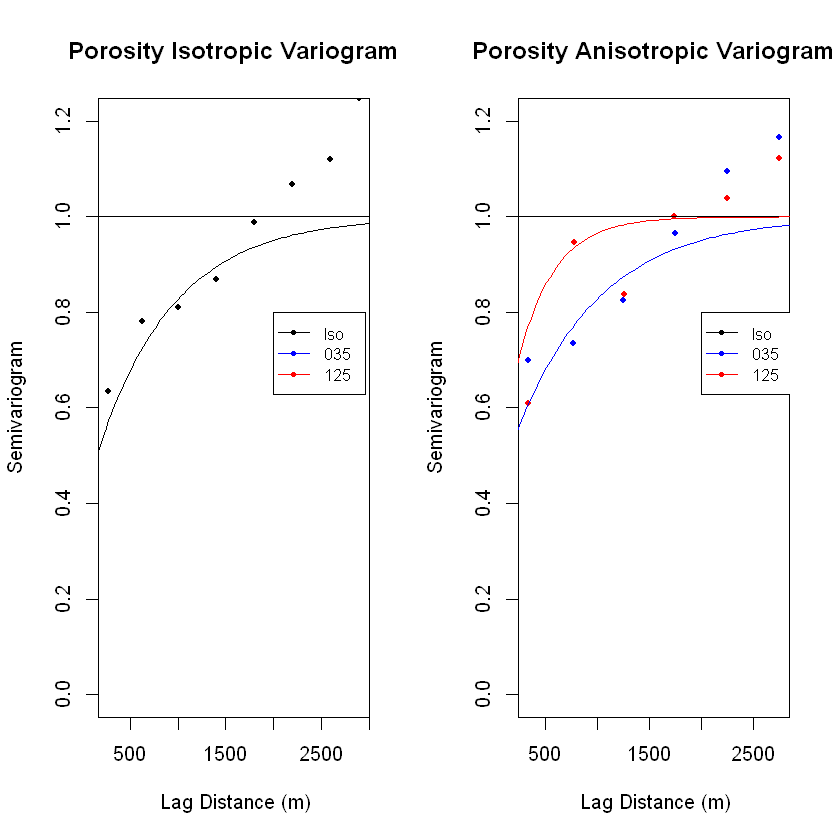

In [10]:
par(mfrow=c(1,2))                              # set up a 2x32 matrix of plots 

name = c("Iso","035","125")                    # make name matrix
color = c("black","blue","red")                # make color matrix

# Isotropic plot

plot(por.vg.iso$dist,por.vg.iso$gamma,main="Porosity Isotropic Variogram",xlab="  Lag Distance (m) ",ylab=" Semivariogram ", col=color[1],ylim=c(0,1.2),pch=20)
abline(h = 1.0)
lines(por.vm.iso$model)

unit_vector = c(1,0,0)                         # unit vector doesn't matter since isotropic
vm.iso <- variogramLine(por.vm.iso,maxdist=3000,min=0.0001,n=100,dir=unit_vector,covariance=FALSE) # calculate variogram model
lines(vm.iso$dist,vm.iso$gamma,col=color[1])   # include variogram model

legend(2000,.8,name, cex=0.8, col=color,pch=c(20,20,20),lty=c(1,1,1)) # add legend

# Anisotropic plot

plot(por.vg.035$dist,por.vg.035$gamma,main="Porosity Anisotropic Variogram",xlab="  Lag Distance (m) ",ylab=" Semivariogram ", col=color[2],ylim=c(0,1.2),pch=20)
points(por.vg.125$dist,por.vg.125$gamma,col=color[3],pch=20)
abline(h = 1.0)
lines(por.vm.iso$model)

unit_vector = c(sin(35*pi/180),cos(35*pi/180),0) # unit vector for 035 azimuth
vm.ani.035 <- variogramLine(por.vm.ani,maxdist=3000,min=0.0001,n=100,dir=unit_vector,covariance=FALSE) # calculate 035 variogram model
lines(vm.ani.035$dist,vm.ani.035$gamma,col=color[2]) # include variogram model 

unit_vector = c(sin(55*pi/180),-1*cos(35*pi/180),0) # unit vector for 125 azimuth
vm.ani.125 <- variogramLine(por.vm.ani,maxdist=3000,min=0.0001,n=100,dir=unit_vector,covariance=FALSE) # calculate 125 variogram model
lines(vm.ani.125$dist,vm.ani.125$gamma,col=color[3]) # include variogram model

legend(2000,.8,name, cex=0.8, col=color,pch=c(20,20,20),lty=c(1,1,1)) # add legend


Hope you found this tutorial useful.  I'm always happy to discuss geostatistics, statistical modeling, uncertainty modeling and machine learning,


![](c:/PGE337/mjp_signature.png)

Michael


Michael Pyrcz, Ph.D., P.Eng.
Associate Professor
The Hildebrand Department of Petroleum and Geosystems Engineering
The University of Texas at Austin